<a href="https://colab.research.google.com/github/hpink97/ML_notebooks/blob/main/04_LSTM_stock_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Create a Long-Short Term Memory Neural Network to predict future stock prices

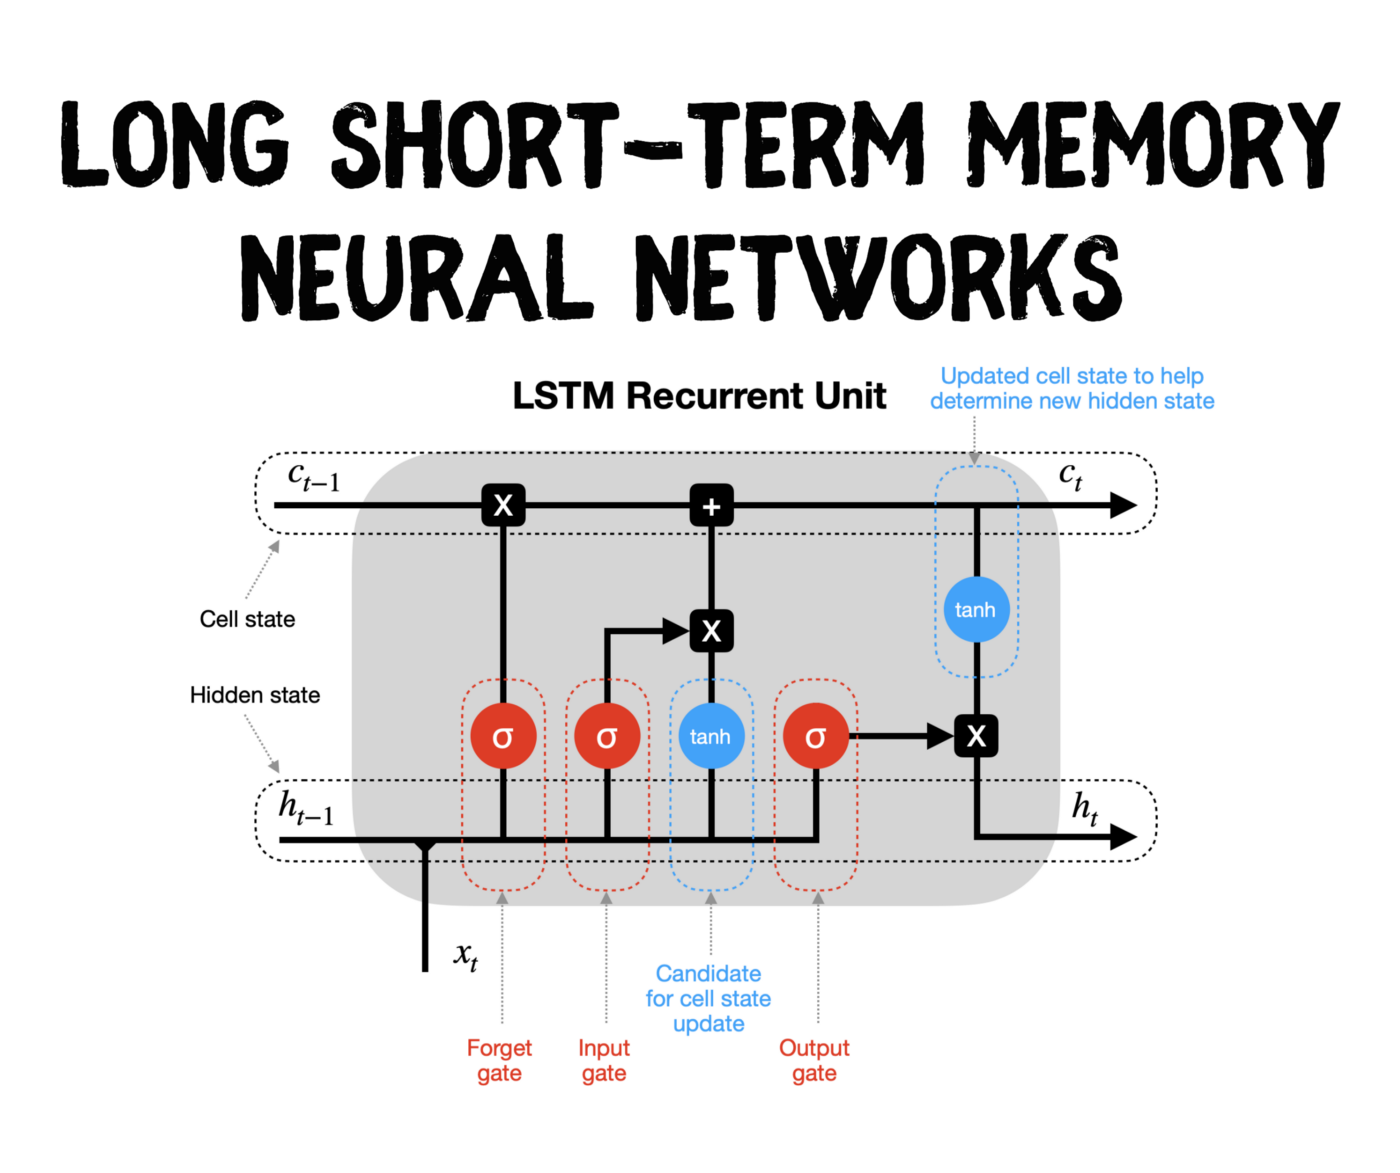

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import math

from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, Dropout, TimeDistributed, Flatten
from keras.activations import sigmoid
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.convolutional import Conv1D, MaxPooling1D
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
import xgboost as xgb



## **Import Data**

Look at S&P500 stock price data from 1990 to 2022, split into 2 files, 1945-2020 and 2012-2022

In [2]:
data_URL = 'https://raw.githubusercontent.com/hpink97/ML_notebooks/main/data'
stocks = ['AAPL','AIG','AMZN','BB',
          'BRK-A','ENRON','GNW','GS',
          'HIG','IBM','KO','MCD','MSFT',
          'NFLX','NVDA','RY','SNAP',
          'SUZLON.NS','TSM','UNITECH.NS',
          'WMT','NKE','BA','PFE','DIS','F',
          'GM','SHEL','XOM']
df = pd.DataFrame()

for ticker in stocks:
    data = pd.read_csv(f"{data_URL}/{ticker}.csv")
    data.columns = data.columns.str.lower()
    data = data[['date', 'open', 'close']]
    data['stock']=ticker
    
    # Append data to the main DataFrame
    df = pd.concat([df, data], ignore_index=True)

df['date'] = pd.to_datetime(df['date'])

df = df[df['date'].dt.year >= 1985]
dfc = df.groupby('stock')['close']
df = df.assign(min=dfc.transform(min), max=dfc.transform(max))
df['scaled_close'] = (df['close'] - df['min']) / (df['max'] - df['min'])

df.head(10)

,date,open,close,stock,min,max,scaled_close
1025,1985-01-02,0.130022,0.124442,AAPL,0.064732,182.009995,0.000328
1026,1985-01-03,0.126674,0.126674,AAPL,0.064732,182.009995,0.000340
1027,1985-01-04,0.126674,0.126674,AAPL,0.064732,182.009995,0.000340
1028,1985-01-07,0.126674,0.126116,AAPL,0.064732,182.009995,0.000337
1029,1985-01-08,0.126116,0.125000,AAPL,0.064732,182.009995,0.000331
1030,1985-01-09,0.128348,0.128348,AAPL,0.064732,182.009995,0.000350
1031,1985-01-10,0.133929,0.133929,AAPL,0.064732,182.009995,0.000380
1032,1985-01-11,0.133929,0.132813,AAPL,0.064732,182.009995,0.000374
1033,1985-01-14,0.136719,0.136719,AAPL,0.064732,182.009995,0.000396
1034,1985-01-15,0.136719,0.133929,AAPL,0.064732,182.009995,0.000380


In [3]:
##count amount of datapoints per stock
df.groupby('stock')['date'].count()

stock
AAPL          9688
AIG           9688
AMZN          6561
BA            9688
BB            6127
BRK-A         9688
DIS           9688
ENRON         1008
F             9688
GM            3160
GNW           4794
GS            6066
HIG           6918
IBM           9688
KO            9688
MCD           9688
MSFT          9387
NFLX          5299
NKE           9688
NVDA          6136
PFE           9688
RY            6961
SHEL          7203
SNAP          1580
SUZLON.NS     4358
TSM           6459
UNITECH.NS    5213
WMT           9688
XOM           9688
Name: date, dtype: int64

Combine the two dataframes together and create a 10-day rolling mean

## Exploratory Data Analysis (EDA)

* Plot stock prices since 1945
* Calculate Annual percentage change

In [4]:
# Convert the 'date' column to a datetime type
weekly_average = df.copy()


# Set the 'date' column as the index
weekly_average.set_index('date', inplace=True)

# Group by stock and resample by week, calculating the mean of 'scaled_close'
weekly_average = weekly_average.groupby('stock')['scaled_close'].resample('W').mean()

# Reset the index to move 'stock' and 'date' from the index back to columns
weekly_average = weekly_average.reset_index()

weekly_average.head(10)


,stock,date,scaled_close
0,AAPL,1985-01-06,0.000336
1,AAPL,1985-01-13,0.000355
2,AAPL,1985-01-20,0.000369
3,AAPL,1985-01-27,0.000369
4,AAPL,1985-02-03,0.000369
5,AAPL,1985-02-10,0.000373
6,AAPL,1985-02-17,0.000352
7,AAPL,1985-02-24,0.000310
8,AAPL,1985-03-03,0.000276
9,AAPL,1985-03-10,0.000230


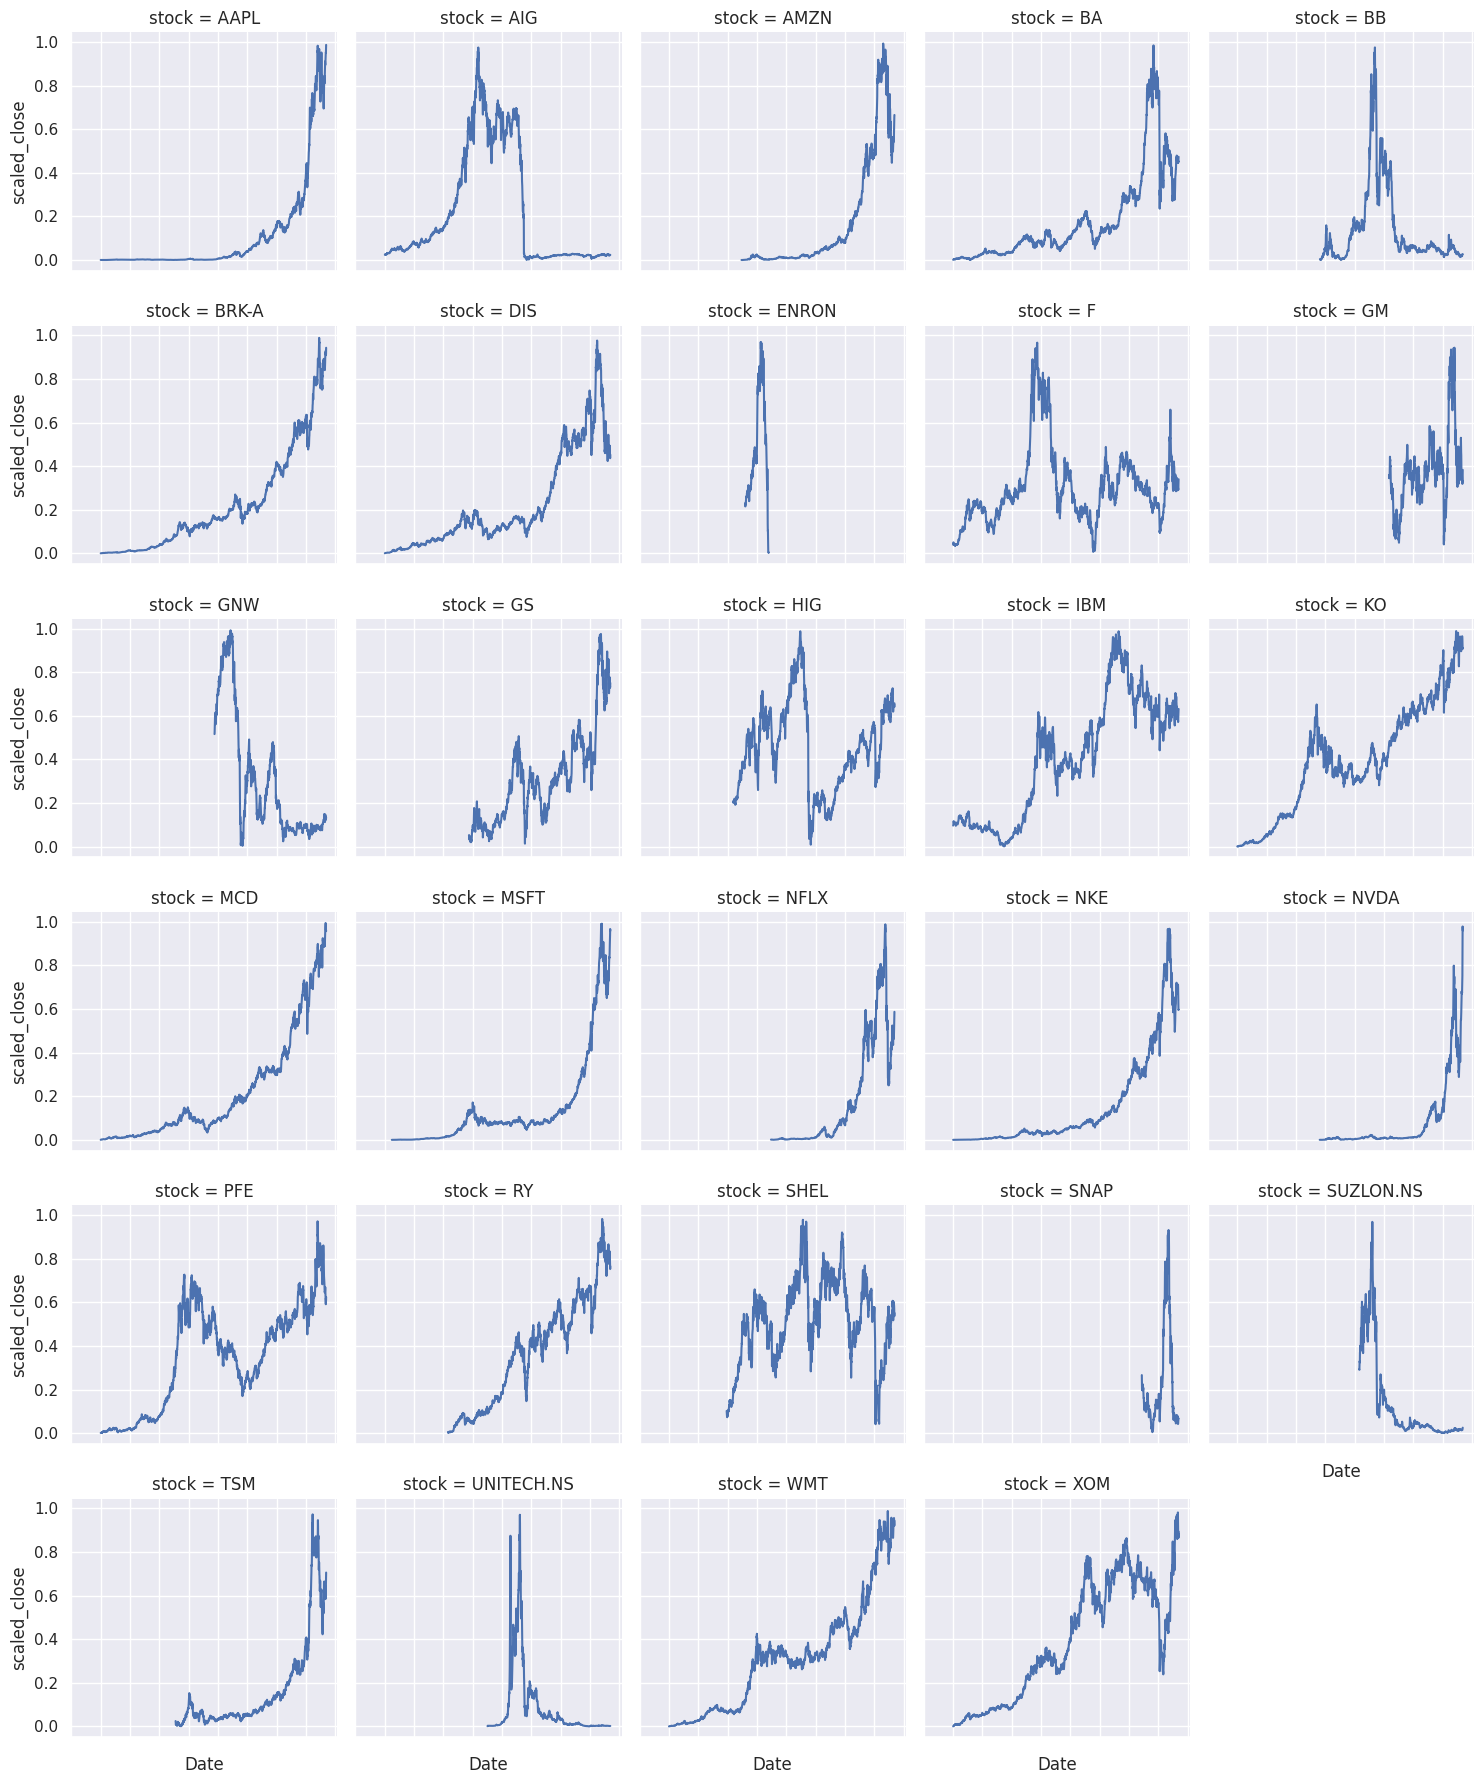

In [5]:

# Set the size of the figure
sns.set(rc={'figure.figsize':(14.0,12)})

# Create the facet grid plot
g = sns.FacetGrid(data=weekly_average, col='stock', col_wrap=5)
g.map(sns.lineplot, 'date', 'scaled_close')

# Set the x-axis label
g.set_xlabels('Date')

# Rotate x-axis labels if needed
g.set_xticklabels(rotation=45)

# Adjust the subplot spacing
plt.tight_layout()

del weekly_average

In [6]:
def get_split(quantile_min, quantile_max, name, df=df):
    min_date = df['date'].quantile(quantile_min)
    max_date = df['date'].quantile(quantile_max)

    df_split = df[(df['date']>= min_date) & (df['date']< max_date)]
    df_split = df_split.dropna()

    df_splits = []
    total_datapoints = 0
    min_dates = []
    max_dates = []
    for stock in df_split['stock'].unique():
        df_stock_split = df_split[df_split['stock'] == stock]
        float_vals = df_stock_split['close'].values.astype('float32')

        datapoints = df_stock_split.shape[0]
        total_datapoints += datapoints
        min_dates.append(df_stock_split['date'].min())
        max_dates.append(df_stock_split['date'].max())
        df_splits.append((stock, float_vals))

    print(f"{name} set contains {total_datapoints} datapoints from {min(min_dates).strftime('%d-%m-%y')} to {max(max_dates).strftime('%d-%m-%y')}")
    return df_splits

  
def to_sequences(dataset, n_past, n_future):
    x = []
    y = []

    for i in range(n_past, len(dataset) - n_future + 1):
        x_vals = dataset[i - n_past:i, 0]
        y_val = dataset[i + n_future - 1, 0]
        y_perc = (y_val - x_vals[-1]) / x_vals[-1]  # Calculate perc_change between last X day and Y day
        y.append(y_perc)

        scaler_X = MinMaxScaler(feature_range=(0, 1))
        x_scaled = scaler_X.fit_transform(x_vals.reshape(-1, 1))
        x_scaled = x_scaled.astype(np.float16)
        x.append(x_scaled)
        
    return np.array(x),np.array(y)


def create_sequences(df_splits, n_past, n_future, print_message = False):
    combined_X = []
    combined_Y = []
    for stock, float_vals in df_splits:
        ##print(f"getting sequences for {stock}")
        x, y = to_sequences(float_vals.reshape(-1, 1), n_past, n_future)
        if print_message:
          print(f"Stock = {stock}. min y = {y.min():.3f}. Max y = {y.max():.3f}. Median y = {np.median(y):.3f}")
        
        combined_X.extend(x)
        combined_Y.extend(y)
    return np.array(combined_X), np.array(combined_Y)




## Peform pre-processing of data for training

## Define a function to convert 

In [7]:
train = get_split(0, 0.7, 'train')
eval = get_split(0.7, 0.85, 'eval')
test = get_split(0.85, 1, 'test')

del df


train set contains 149200 datapoints from 02-01-85 to 01-04-14
eval set contains 31966 datapoints from 02-04-14 to 20-11-18
test set contains 31966 datapoints from 21-11-18 to 08-06-23


In [8]:
n_past = 6*4*5 ##approx 6 months of previous data to train on
n_future = 6*5 ## predict 6 weeks into the future

trainX, trainY_unscaled = create_sequences(train, n_past,n_future)
del train 
validX, validY_unscaled = create_sequences(eval, n_past,n_future) 
del eval
testX, testY_unscaled = create_sequences(test, n_past,n_future, print_message=True)
del test



Stock = AAPL. min y = -0.299. Max y = 0.383. Median y = 0.050
Stock = AIG. min y = -0.640. Max y = 0.689. Median y = 0.014
Stock = AMZN. min y = -0.378. Max y = 0.438. Median y = 0.008
Stock = BB. min y = -0.574. Max y = 2.076. Median y = -0.025
Stock = BRK-A. min y = -0.296. Max y = 0.210. Median y = 0.025
Stock = GNW. min y = -0.407. Max y = 0.846. Median y = 0.027
Stock = GS. min y = -0.433. Max y = 0.327. Median y = 0.018
Stock = HIG. min y = -0.545. Max y = 0.447. Median y = 0.015
Stock = IBM. min y = -0.391. Max y = 0.293. Median y = -0.004
Stock = KO. min y = -0.365. Max y = 0.209. Median y = 0.019
Stock = MCD. min y = -0.360. Max y = 0.366. Median y = 0.014
Stock = MSFT. min y = -0.261. Max y = 0.329. Median y = 0.039
Stock = NFLX. min y = -0.575. Max y = 0.426. Median y = 0.029
Stock = NVDA. min y = -0.420. Max y = 0.590. Median y = 0.086
Stock = RY. min y = -0.385. Max y = 0.231. Median y = 0.013
Stock = SNAP. min y = -0.628. Max y = 1.104. Median y = 0.007
Stock = SUZLON.NS.

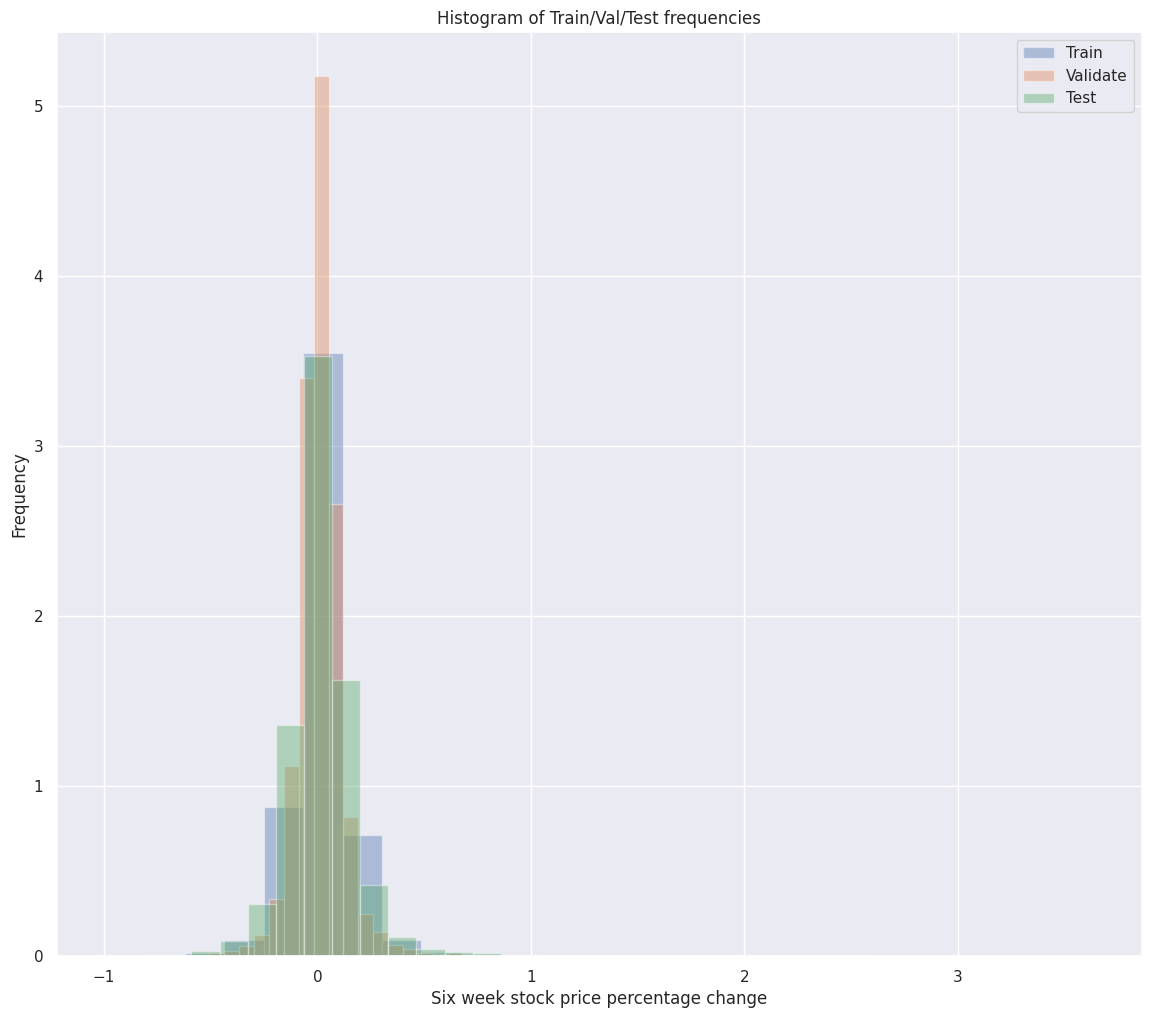

In [9]:
plt.hist(trainY_unscaled, bins=25, alpha=0.4, label='Train', density=True)
plt.hist(validY_unscaled, bins=25, alpha=0.4, label='Validate', density=True)
plt.hist(testY_unscaled, bins=25, alpha=0.4, label='Test', density=True)

# Add labels and title
plt.xlabel('Six week stock price percentage change')
plt.ylabel('Frequency')
plt.title('Histogram of Train/Val/Test frequencies')

# Add legend
plt.legend()

# Show the plot
plt.show()






In [10]:
##scale Y between 0 and 1 also
scaler_y = MinMaxScaler(feature_range=(0, 1))
trainY = scaler_y.fit_transform(trainY_unscaled.reshape(-1, 1))
validY = scaler_y.transform(validY_unscaled.reshape(-1, 1))
testY = scaler_y.transform(testY_unscaled.reshape(-1, 1))



In [73]:
##reshape data for LSTM
trainX = np.reshape(trainX, (trainX.shape[0], 1, n_past))
validX = np.reshape(validX, (validX.shape[0], 1, n_past))
testX = np.reshape(testX, (testX.shape[0], 1, n_past))

print(f"Stock data has been into train ({len(trainX)} datapoints), validation ({len(validX)} datapoints) and test ({len(testX)} datapoints). ")


Stock data has been into train (145028 datapoints), validation (27794 datapoints) and test (27794 datapoints). 


In [12]:
trainX.shape

(145028, 1, 120)

## Build the model

We're going to build a relatively LSTM recurrent neural network with dropout regularisation (hopefully avoid too much overfitting)


In [57]:
#print('Single LSTM with hidden Dense...')
lstm = Sequential()
lstm.add(LSTM(units = 24,activation=sigmoid, input_shape = (None, n_past)))
lstm.add(Dropout(0.125))
lstm.add(Dense(8))
lstm.add(Dense(1))
lstm.compile(optimizer = 'adam', loss = 'mse',metrics=['mae'])
lstm.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, 24)                13920     
                                                                 
 dropout_10 (Dropout)        (None, 24)                0         
                                                                 
 dense_13 (Dense)            (None, 8)                 200       
                                                                 
 dense_14 (Dense)            (None, 1)                 9         
                                                                 
Total params: 14,129
Trainable params: 14,129
Non-trainable params: 0
_________________________________________________________________


In [58]:
###fit to model 

es = EarlyStopping(monitor='val_loss', 
                   min_delta=1e-5,
                   patience=25,
                   verbose=1,
                   mode='auto',
                   restore_best_weights=True)

batch_size =2048

history = lstm.fit(trainX, trainY, validation_data=(validX, validY),
          verbose=2, epochs=1000,
          batch_size=batch_size, 
          callbacks=[es])

Epoch 1/1000
71/71 - 3s - loss: 0.0106 - mae: 0.0773 - val_loss: 8.5329e-04 - val_mae: 0.0212 - 3s/epoch - 44ms/step
Epoch 2/1000
71/71 - 0s - loss: 0.0032 - mae: 0.0425 - val_loss: 7.3579e-04 - val_mae: 0.0192 - 486ms/epoch - 7ms/step
Epoch 3/1000
71/71 - 1s - loss: 0.0021 - mae: 0.0338 - val_loss: 6.8103e-04 - val_mae: 0.0182 - 666ms/epoch - 9ms/step
Epoch 4/1000
71/71 - 1s - loss: 0.0017 - mae: 0.0298 - val_loss: 6.5393e-04 - val_mae: 0.0177 - 850ms/epoch - 12ms/step
Epoch 5/1000
71/71 - 1s - loss: 0.0015 - mae: 0.0273 - val_loss: 6.3417e-04 - val_mae: 0.0173 - 837ms/epoch - 12ms/step
Epoch 6/1000
71/71 - 1s - loss: 0.0014 - mae: 0.0255 - val_loss: 6.2549e-04 - val_mae: 0.0172 - 670ms/epoch - 9ms/step
Epoch 7/1000
71/71 - 1s - loss: 0.0013 - mae: 0.0242 - val_loss: 6.0803e-04 - val_mae: 0.0168 - 501ms/epoch - 7ms/step
Epoch 8/1000
71/71 - 0s - loss: 0.0012 - mae: 0.0232 - val_loss: 6.0369e-04 - val_mae: 0.0167 - 471ms/epoch - 7ms/step
Epoch 9/1000
71/71 - 1s - loss: 0.0012 - mae: 0.

<Axes: xlabel='epoch', ylabel='value'>

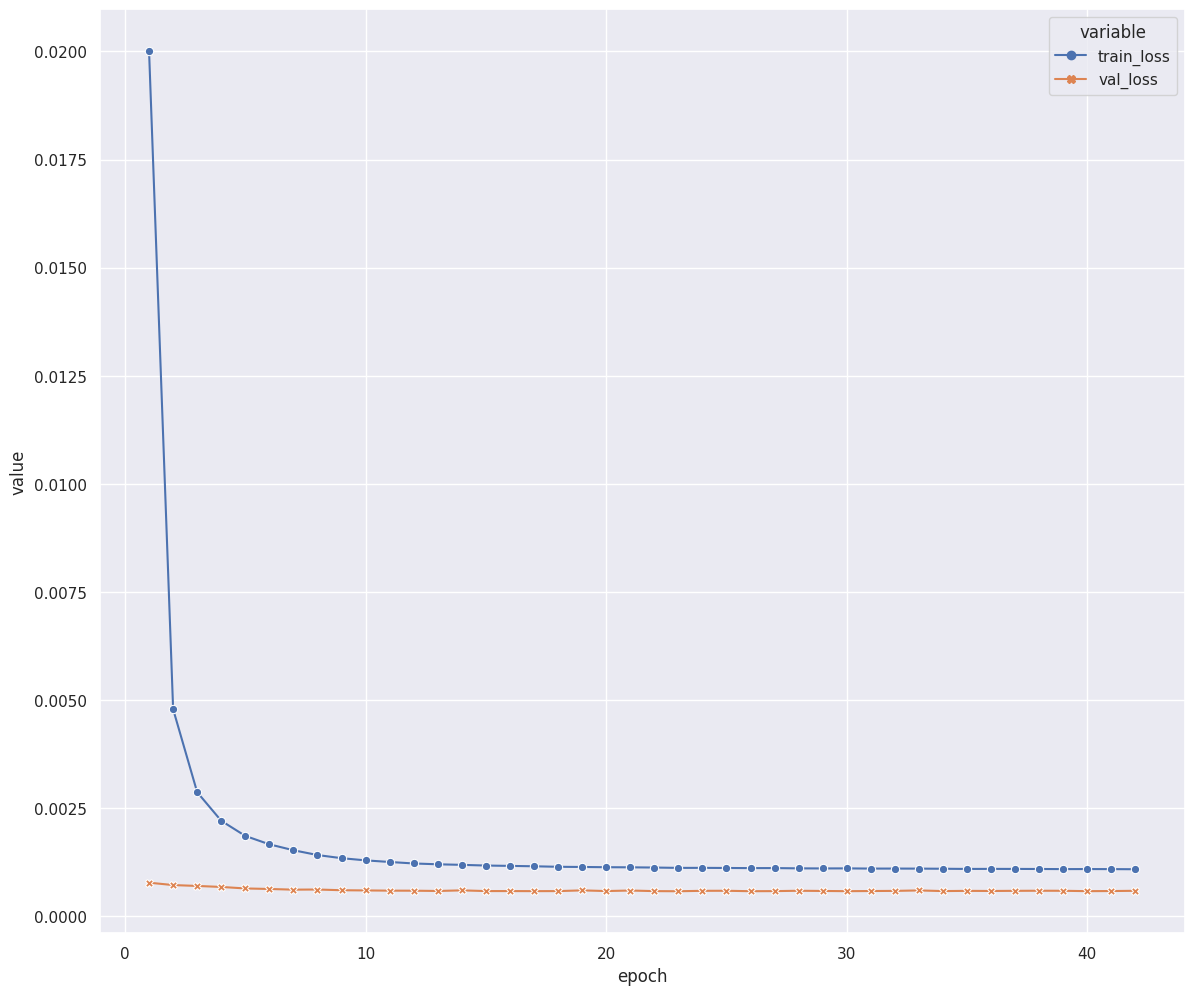

In [22]:
df = pd.DataFrame({'epoch':range(1, len(history.history['loss'])+1),
              'train_loss':history.history['loss'],
              'val_loss':history.history['val_loss']})

df_pivot = pd.melt(df, id_vars=['epoch'], value_vars=['train_loss','val_loss'])

sns.lineplot(data=df_pivot, x="epoch", y="value", hue="variable",style="variable",
    markers=True, dashes=False)



```

## Stacked LSTM

In [45]:

# Define the model
stacked_lstm = Sequential()
stacked_lstm.add(LSTM(units=64, input_shape=(None, n_past), return_sequences=True))
stacked_lstm.add(Dropout(0.25))
stacked_lstm.add(LSTM(units=16))
stacked_lstm.add(Dropout(0.125))
stacked_lstm.add(Dense(12, activation='relu'))
stacked_lstm.add(Dense(1))

stacked_lstm.compile(optimizer='adam', loss='mse', metrics=['mae'])
stacked_lstm.summary()

# Train the model
history_stacked_lstm = stacked_lstm.fit(trainX, trainY, 
                                        validation_data=(validX, validY),
                                        verbose=2, epochs=1000, 
                                        batch_size=batch_size, 
                                        callbacks=[es])


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, None, 64)          47360     
                                                                 
 dropout_8 (Dropout)         (None, None, 64)          0         
                                                                 
 lstm_9 (LSTM)               (None, 16)                5184      
                                                                 
 dropout_9 (Dropout)         (None, 16)                0         
                                                                 
 dense_10 (Dense)            (None, 12)                204       
                                                                 
 dense_11 (Dense)            (None, 1)                 13        
                                                                 
Total params: 52,761
Trainable params: 52,761
Non-trai

## Try a CNN-LSTM

In [49]:
cnn_lstm = Sequential()
cnn_lstm.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, n_past,1)))
cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=2)))
cnn_lstm.add(TimeDistributed(Flatten()))
cnn_lstm.add(LSTM(50, activation='relu'))
cnn_lstm.add(Dense(1))
cnn_lstm.compile(optimizer='adam', loss='mse')

history_cnn_lstm = cnn_lstm.fit(trainX, trainY, validation_data=(validX, validY),
                    verbose=2, epochs=200, batch_size=batch_size, callbacks=[es])

Epoch 1/200
71/71 - 8s - loss: 0.0039 - val_loss: 6.5754e-04 - 8s/epoch - 120ms/step
Epoch 2/200
71/71 - 1s - loss: 0.0012 - val_loss: 5.8433e-04 - 1s/epoch - 19ms/step
Epoch 3/200
71/71 - 1s - loss: 0.0011 - val_loss: 5.9491e-04 - 1s/epoch - 16ms/step
Epoch 4/200
71/71 - 1s - loss: 0.0011 - val_loss: 5.8677e-04 - 1s/epoch - 17ms/step
Epoch 5/200
71/71 - 1s - loss: 0.0011 - val_loss: 5.8840e-04 - 1s/epoch - 17ms/step
Epoch 6/200
71/71 - 1s - loss: 0.0011 - val_loss: 5.8447e-04 - 1s/epoch - 16ms/step
Epoch 7/200
71/71 - 1s - loss: 0.0011 - val_loss: 5.7998e-04 - 1s/epoch - 16ms/step
Epoch 8/200
71/71 - 1s - loss: 0.0011 - val_loss: 5.8081e-04 - 1s/epoch - 17ms/step
Epoch 9/200
71/71 - 1s - loss: 0.0011 - val_loss: 5.8327e-04 - 1s/epoch - 16ms/step
Epoch 10/200
71/71 - 1s - loss: 0.0011 - val_loss: 5.7975e-04 - 1s/epoch - 16ms/step
Epoch 11/200
71/71 - 1s - loss: 0.0011 - val_loss: 5.8309e-04 - 1s/epoch - 18ms/step
Epoch 12/200
71/71 - 1s - loss: 0.0011 - val_loss: 5.8640e-04 - 1s/epoch 

In [90]:
from keras import Model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, MultiHeadAttention, Input, LayerNormalization, GlobalAveragePooling1D

# transformer block
def transformer_block(embed_dim, num_heads, ff_dim):
    inputs = Input(shape=(None, embed_dim))
    x = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(inputs, inputs)
    x = Dropout(0.1)(x)
    x = LayerNormalization(epsilon=1e-6)(inputs + x)
    x = Dense(ff_dim, activation="relu")(x)
    x = Dense(embed_dim)(x)
    x = Dropout(0.1)(x)
    x = LayerNormalization(epsilon=1e-6)(inputs + x)
    outputs = Dense(embed_dim)(x)
    return Model(inputs=inputs, outputs=outputs)

embed_dim = 100  # Embedding size for each token
num_heads = 4  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = Input(shape=(1,120))
x = Dense(embed_dim)(inputs)  # Add this line to transform inputs
transformer = transformer_block(embed_dim, num_heads, ff_dim)
x = transformer(x)
x = GlobalAveragePooling1D()(x)
x = Dense(6, activation="relu")(x)
x = Dense(1)(x)
transformer = Model(inputs=inputs, outputs=x)

transformer.compile(optimizer='adam', loss='mse', metrics=['mae'])
transformer.summary()

trainX = np.reshape(trainX, (trainX.shape[0], 1, n_past))
validX = np.reshape(validX, (validX.shape[0], 1, n_past))
testX = np.reshape(testX, (testX.shape[0], 1, n_past))

history_transformer = transformer.fit(trainX, trainY, 
                                   validation_data=(validX, validY),
                                   verbose=2, epochs=200, 
                                   batch_size=batch_size, 
                                   callbacks=[es])

Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, 1, 120)]          0         
                                                                 
 dense_78 (Dense)            (None, 1, 100)            12100     
                                                                 
 model_19 (Functional)       (None, None, 100)         178332    
                                                                 
 global_average_pooling1d_9   (None, 100)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_82 (Dense)            (None, 6)                 606       
                                                                 
 dense_83 (Dense)            (None, 1)                 7         
                                                          

## Asses predictions



In [91]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, classification_report

def assess_predictions(model, y_true, prefix, results_df=None, plot=True):
    y_pred = scaler_y.inverse_transform(model.predict(testX).reshape(-1, 1))

    # Calculate evaluation metrics
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    # Append categorical predictions to the results DataFrame
    df = pd.DataFrame({'Model': [prefix],
                            'RMSE': [rmse],
                            'MAE': [mae],
                            'R-squared': [r2]})

    # Concatenate results with inputted DataFrame if provided
    if results_df is not None:
        df = pd.concat([df, results_df], ignore_index=True)

    # Create scatter plot
    if plot:
        plt.figure(figsize=(8, 6))
        sns.regplot(x=y_true, y=y_pred, scatter_kws={'alpha': 0.15})
        plt.xlabel('True Values')
        plt.ylabel('Predicted Values')
        plt.title('True vs Predicted Values')
        plt.show()

    # Return results DataFrame and modified inputted DataFrame
    return df




Using the Median Absolute Percentage Error (MAPE), our LSTM is (marginally) more accurate than our "lastX_equals_Y" model - presuming stock price will be identical to that of 6 weeks ago

869/869 [==============================] - 2s 2ms/step


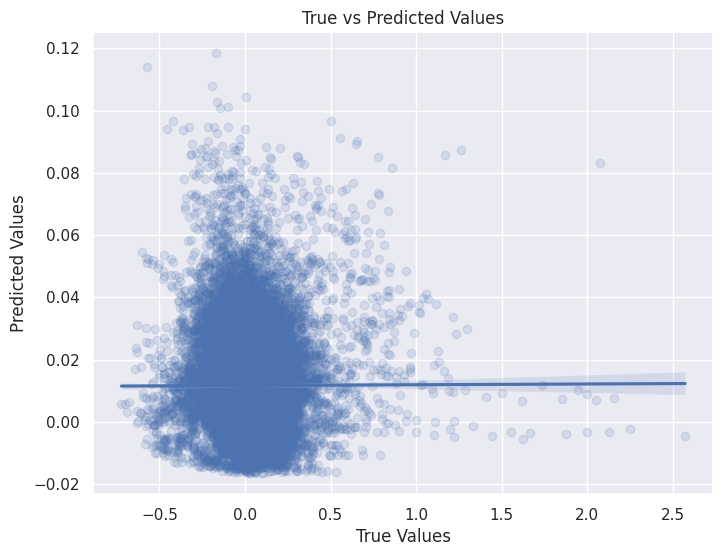

In [92]:
results = assess_predictions(lstm, testY_unscaled, 'simple LSTM model', results_df=pd.DataFrame())




869/869 [==============================] - 2s 3ms/step


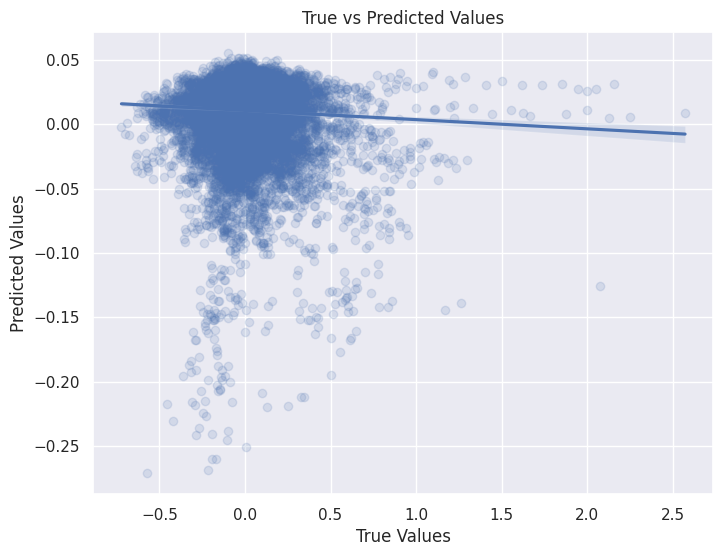

In [93]:
results = assess_predictions(stacked_lstm, testY_unscaled,
                             'stacked LSTM model',
                             results_df=results)

869/869 [==============================] - 2s 3ms/step


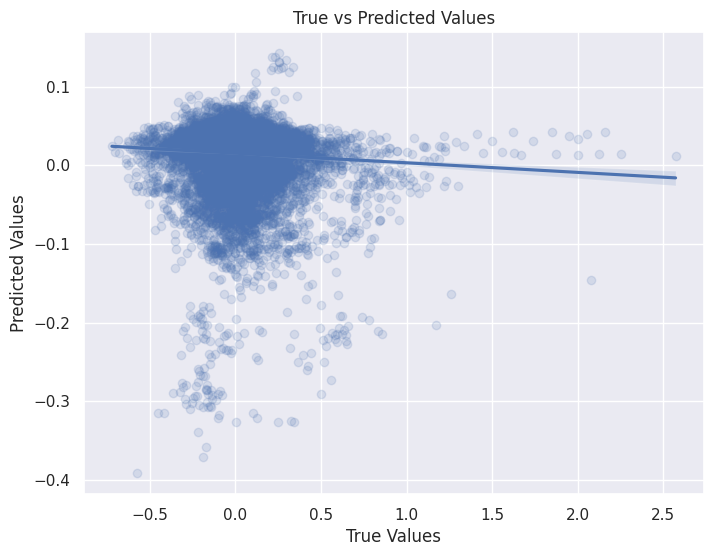

In [94]:
results = assess_predictions(cnn_lstm, testY_unscaled,
                             'CNN LSTM model',
                             results_df=results)

869/869 [==============================] - 3s 3ms/step


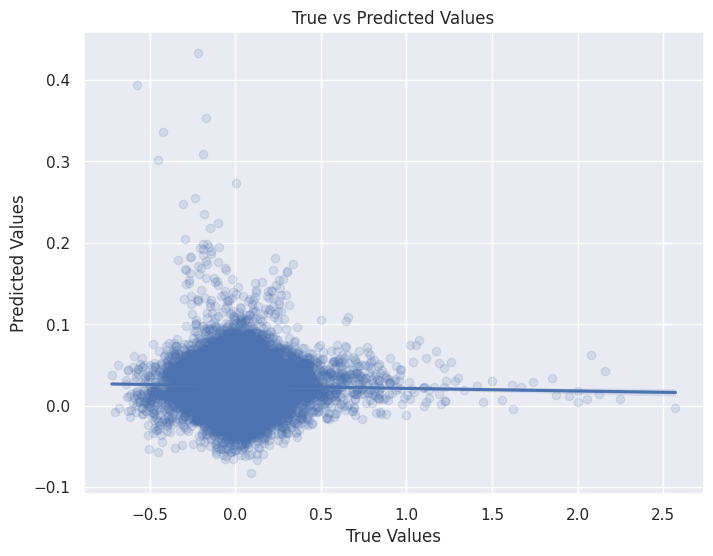

In [95]:
results = assess_predictions(transformer, testY_unscaled,
                             'Transformer',
                             results_df=results)

In [97]:
results

,Model,RMSE,MAE,R-squared
0,Transformer,0.166237,0.110510,-0.028924
1,CNN LSTM model,0.169292,0.111057,-0.067091
2,stacked LSTM model,0.167088,0.108516,-0.039488
3,simple LSTM model,0.164741,0.108574,-0.010490
